In [1]:
!nvidia-smi

Wed Dec 18 16:57:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install tensorflow_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-12-18 16:58:21.680012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 16:58:21.680152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 16:58:21.813849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Display TensorFlow and TensorFlow Hub versions, execution mode, and GPU availability status
print(f"TensorFlow Version: {tf.__version__}")
print(f"Eager Execution: {'Enabled' if tf.executing_eagerly() else 'Disabled'}")
print(f"TensorFlow Hub Version: {hub.__version__}")
print(f"GPU Status: {'Available' if tf.config.experimental.list_physical_devices('GPU') else 'Not Available'}")

TensorFlow Version: 2.15.0
Eager Execution: Enabled
TensorFlow Hub Version: 0.16.1
GPU Status: Available


In [5]:
# Load the dataset and display its dimensions
data_frame = pd.read_csv("train-sample.csv")
data_frame.shape

(140272, 15)

In [6]:
data_frame.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
140267,2982729,06/06/2010 01:03:41,8303,09/15/2008 15:40:08,520,34,Is it possible to implement bitwise operators ...,I am facing a rather peculiar problem. I am wo...,bitwise-operators,discrete-mathematics,compiler-optimization,NaN,NaN,NaN,open
140268,8809105,01/10/2012 19:13:53,1130251,01/04/2012 15:31:10,1,0,Ruby on Rails: MySql Gem does not work: uninit...,I have the following installed:\r\nMac Os 10.7...,mysql,ruby-on-rails,gem,osx-lion,NaN,NaN,open
140269,10674791,05/20/2012 15:36:31,1388595,05/11/2012 04:43:47,4,0,deleting image from image folder,I am working with an asp.net application.I wan...,asp.net,NaN,NaN,NaN,NaN,05/21/2012 21:21:27,not a real question
140270,3997045,10/22/2010 13:04:30,484232,10/22/2010 13:04:30,1,0,Need help making HTML's,Hi to all the gurus out there.\r\n\r\nAnybody ...,html,copy,remove,move,NaN,10/22/2010 13:10:28,not a real question
140271,11570849,07/19/2012 23:36:57,1539253,07/19/2012 22:17:04,3,1,How dangerous is it to output certain content ...,Following on from a question I asked about esc...,php,content-management-system,NaN,NaN,NaN,NaN,open


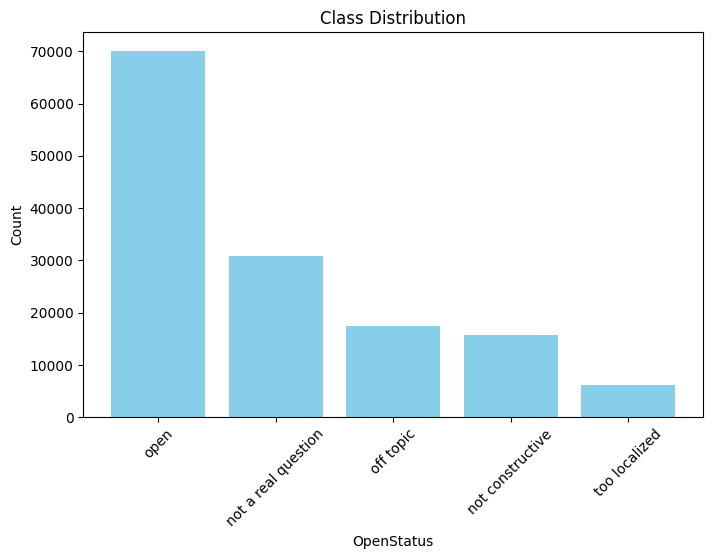

In [7]:
# Plot the distribution of the 'OpenStatus' column
class_counts = data_frame['OpenStatus'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [8]:
# Display the count of samples for each class in the 'OpenStatus' column
print(class_counts)

OpenStatus
open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: count, dtype: int64


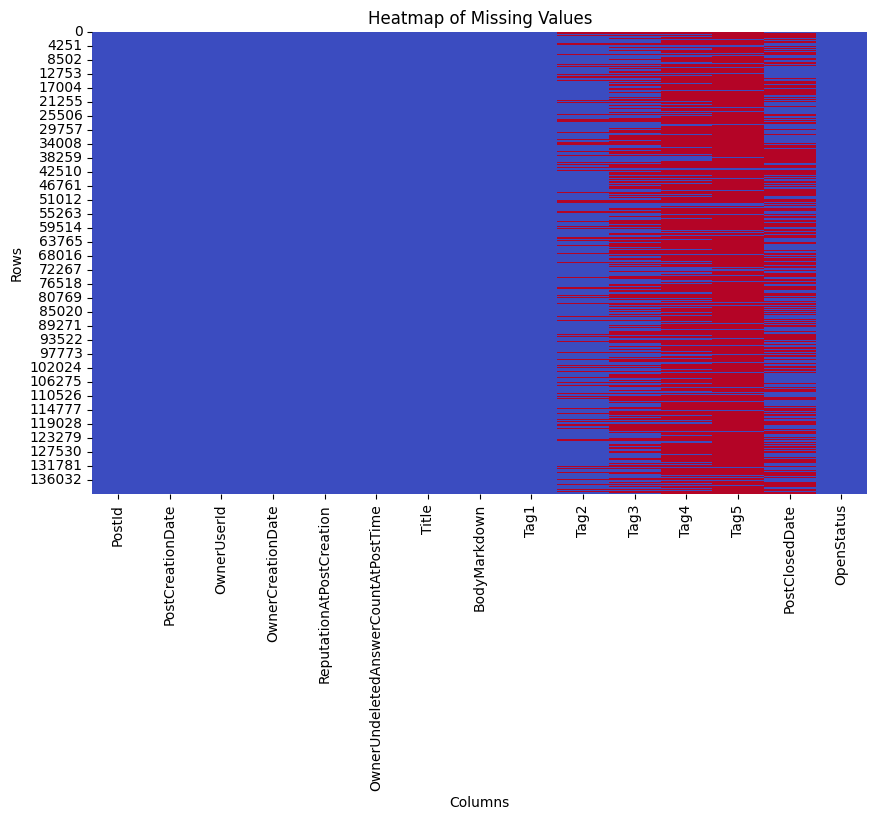

In [9]:
#check for null values
import seaborn as sns

# Identify and visualize missing values in the DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(data_frame.isnull(), annot=False, cmap='coolwarm', cbar=False)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [10]:
# Split the dataset into training (70%), validation (20%), and test (10%) sets
train_data, temp_data = train_test_split(data_frame, test_size=0.3, random_state=42, stratify=data_frame['OpenStatus'])
validation_data, test_data = train_test_split(temp_data, test_size=0.333, random_state=42, stratify=temp_data['OpenStatus'])

# Display the shapes of the train, validation, and test datasets
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {validation_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (98190, 15)
Validation Data Shape: (28068, 15)
Test Data Shape: (14014, 15)


In [11]:
# Display the count of samples for each class in the training dataset
train_class_counts = train_data['OpenStatus'].value_counts()
print("Class Distribution in Training Data:\n", train_class_counts)

Class Distribution in Training Data:
 OpenStatus
open                   49095
not a real question    21552
off topic              12271
not constructive       10961
too localized           4311
Name: count, dtype: int64


In [12]:
from sklearn.utils import resample

# Separating the classes in the training dataset
open_class = train_data[train_data['OpenStatus'] == 'open']
not_a_real_question_class = train_data[train_data['OpenStatus'] == 'not a real question']
off_topic_class = train_data[train_data['OpenStatus'] == 'off topic']
not_constructive_class = train_data[train_data['OpenStatus'] == 'not constructive']
too_localized_class = train_data[train_data['OpenStatus'] == 'too localized']

# Downsampling all classes to match the size of the 'too localized' class
target_class_size = len(too_localized_class)

open_class_resampled = resample(open_class, replace=False, n_samples=target_class_size, random_state=42)
not_a_real_question_class_resampled = resample(not_a_real_question_class, replace=False, n_samples=target_class_size, random_state=42)
off_topic_class_resampled = resample(off_topic_class, replace=False, n_samples=target_class_size, random_state=42)
not_constructive_class_resampled = resample(not_constructive_class, replace=False, n_samples=target_class_size, random_state=42)

# Combine all resampled classes into a single dataset
train_data_resampled = pd.concat([open_class_resampled, 
                                  not_a_real_question_class_resampled, 
                                  off_topic_class_resampled, 
                                  not_constructive_class_resampled, 
                                  too_localized_class])

# Shuffle the downsampled dataset
train_data_resampled = train_data_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
train_data_resampled.shape

(21555, 15)

In [14]:
# Display the count of samples for each class in the downsampled training dataset
class_counts_resampled = train_data_resampled['OpenStatus'].value_counts()
print("Class Distribution in Resampled Training Data:\n", class_counts_resampled)

Class Distribution in Resampled Training Data:
 OpenStatus
off topic              4311
open                   4311
too localized          4311
not a real question    4311
not constructive       4311
Name: count, dtype: int64


In [15]:
train_data_resampled.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
21550,3313822,07/22/2010 21:54:25,270863,02/11/2010 06:24:29,1,0,"What are Geeks ""To do list""",I am wondering as geeks get older & older what...,todo,NaN,NaN,NaN,NaN,07/22/2010 22:00:16,off topic
21551,5927295,05/08/2011 12:00:49,743235,05/07/2011 16:56:07,1,0,Traffic Dropping Rapidly when number of online...,Something is wrong with the VPS server and i d...,wordpress,vps,NaN,NaN,NaN,05/09/2011 01:39:33,off topic
21552,9680455,03/13/2012 08:20:17,722525,04/24/2011 10:32:15,11,0,Create a WYSIWYG Editor Plugin,i have a task to create a wysiwyg editor plugi...,eclipse,eclipse-plugin,wysiwyg,NaN,NaN,03/14/2012 17:33:56,not a real question
21553,6483557,06/26/2011 11:14:32,348261,05/23/2010 12:33:53,424,23,When would be the right time to end a Flurry s...,I just have a normal app with a few activities...,android,session,activity,end,flurry,NaN,open
21554,93890,09/18/2008 15:59:46,12178,09/16/2008 13:29:35,34,7,Which language to choose and when?,Sorry if the title is misleading!\r\n\r\nTake ...,programming-languages,NaN,NaN,NaN,NaN,04/20/2012 11:10:09,not constructive


In [16]:
# Selecting specific columns for the train, validation, and test datasets
selected_columns = ['Title', 'BodyMarkdown', 'OpenStatus', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']

train_data_resampled = train_data_resampled[selected_columns]
validation_data = validation_data[selected_columns]
test_data = test_data[selected_columns]

In [17]:
train_data_resampled.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5
21550,"What are Geeks ""To do list""",I am wondering as geeks get older & older what...,off topic,todo,NaN,NaN,NaN,NaN
21551,Traffic Dropping Rapidly when number of online...,Something is wrong with the VPS server and i d...,off topic,wordpress,vps,NaN,NaN,NaN
21552,Create a WYSIWYG Editor Plugin,i have a task to create a wysiwyg editor plugi...,not a real question,eclipse,eclipse-plugin,wysiwyg,NaN,NaN
21553,When would be the right time to end a Flurry s...,I just have a normal app with a few activities...,open,android,session,activity,end,flurry
21554,Which language to choose and when?,Sorry if the title is misleading!\r\n\r\nTake ...,not constructive,programming-languages,NaN,NaN,NaN,NaN


In [18]:
# Creating the 'text' column for the train, validation, and test datasets
def create_text_column(df):
    # Using a vectorized approach with apply for efficiency
    df['text'] = df.apply(lambda row: f"Title: '{row['Title']}'  Body: '{row['BodyMarkdown']}'", axis=1)
    return df

# Applying the function to train, validation, and test datasets
train_data_resampled = create_text_column(train_data_resampled)
validation_data = create_text_column(validation_data)
test_data = create_text_column(test_data)

In [19]:
train_data_resampled.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
21550,"What are Geeks ""To do list""",I am wondering as geeks get older & older what...,off topic,todo,NaN,NaN,NaN,NaN,"Title: 'What are Geeks ""To do list""' Body: 'I..."
21551,Traffic Dropping Rapidly when number of online...,Something is wrong with the VPS server and i d...,off topic,wordpress,vps,NaN,NaN,NaN,Title: 'Traffic Dropping Rapidly when number o...
21552,Create a WYSIWYG Editor Plugin,i have a task to create a wysiwyg editor plugi...,not a real question,eclipse,eclipse-plugin,wysiwyg,NaN,NaN,Title: 'Create a WYSIWYG Editor Plugin' Body:...
21553,When would be the right time to end a Flurry s...,I just have a normal app with a few activities...,open,android,session,activity,end,flurry,Title: 'When would be the right time to end a ...
21554,Which language to choose and when?,Sorry if the title is misleading!\r\n\r\nTake ...,not constructive,programming-languages,NaN,NaN,NaN,NaN,Title: 'Which language to choose and when?' B...


In [20]:
# Dropping the specified columns from the train, validation, and test datasets
columns_to_drop = ['Title', 'BodyMarkdown']

train_data_resampled.drop(columns=columns_to_drop, inplace=True)
validation_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [21]:
train_data_resampled.shape

(21555, 7)

In [22]:
train_data_resampled.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
21550,off topic,todo,NaN,NaN,NaN,NaN,"Title: 'What are Geeks ""To do list""' Body: 'I..."
21551,off topic,wordpress,vps,NaN,NaN,NaN,Title: 'Traffic Dropping Rapidly when number o...
21552,not a real question,eclipse,eclipse-plugin,wysiwyg,NaN,NaN,Title: 'Create a WYSIWYG Editor Plugin' Body:...
21553,open,android,session,activity,end,flurry,Title: 'When would be the right time to end a ...
21554,not constructive,programming-languages,NaN,NaN,NaN,NaN,Title: 'Which language to choose and when?' B...


In [23]:
# Displaying the text and target class for the first row in the training dataset
sample_row = train_data_resampled.iloc[0]

print("Text: ")
print("________________________")
print(sample_row['text'], end='\n\n\n\n')

print("Target Class:")
print("________________________")
print(sample_row['OpenStatus'])

Text: 
________________________
Title: 'what does txqueuelen:0 mean on a NIC?'  Body: '
what does txqueuelen:0 mean on an interface?  

shouldn't it be set to a number? 

would it at any point effect my UDP traffic?

thank you,'



Target Class:
________________________
off topic


In [24]:
# Define label mapping
custom_label_mapping = {'open': 0, 
                        'not a real question': 1, 
                        'off topic': 2,
                        'not constructive': 3, 
                        'too localized': 4
                       }

# Function to encode labels based on the custom mapping
def encode_labels(df):
    df['OpenStatus_encoded'] = df['OpenStatus'].map(custom_label_mapping)
    return df

# Apply the encoding to train, validation, and test datasets
train_data_resampled = encode_labels(train_data_resampled)
validation_data = encode_labels(validation_data)
test_data = encode_labels(test_data)


In [25]:
train_data_resampled.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text,OpenStatus_encoded
21550,off topic,todo,NaN,NaN,NaN,NaN,"Title: 'What are Geeks ""To do list""' Body: 'I...",2
21551,off topic,wordpress,vps,NaN,NaN,NaN,Title: 'Traffic Dropping Rapidly when number o...,2
21552,not a real question,eclipse,eclipse-plugin,wysiwyg,NaN,NaN,Title: 'Create a WYSIWYG Editor Plugin' Body:...,1
21553,open,android,session,activity,end,flurry,Title: 'When would be the right time to end a ...,0
21554,not constructive,programming-languages,NaN,NaN,NaN,NaN,Title: 'Which language to choose and when?' B...,3


In [26]:
train_data_resampled.shape

(21555, 8)

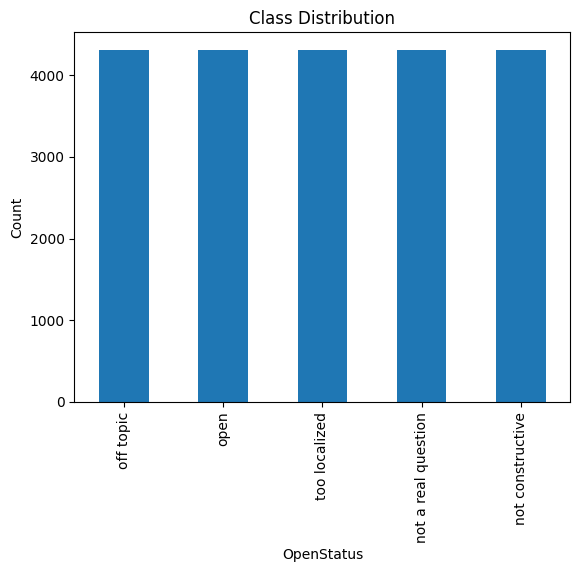

In [27]:
# Plotting the class distribution for 'OpenStatus' in the training dataset
train_data_resampled['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()


In [28]:
# Assigning features and target variables for train, validation, and test datasets
X_train = train_data_resampled["text"]
y_train = train_data_resampled["OpenStatus_encoded"]

X_valid = validation_data["text"]
y_valid = validation_data["OpenStatus_encoded"]

X_test = test_data["text"]
y_test = test_data["OpenStatus_encoded"]

# Displaying the shapes of the feature and target datasets
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)


(21555,)
(21555,)
(28068,)
(28068,)
(14014,)
(14014,)


In [29]:
import tensorflow_hub as hub

# Load the preprocessor layer for BERT
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs, input mask, and input type IDs
print("Token IDs:", tokenized_output['input_word_ids'])
print("Input Mask:", tokenized_output['input_mask'])
print("Input Type IDs:", tokenized_output['input_type_ids'])


Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


Token IDs: tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
Input Mask: tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [30]:
# Building the model

# Input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# Preprocessor for BERT tokenization
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)

# BERT encoder
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)

# Extract pooled and sequence outputs from the encoder
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

# Classification layers
# Add dropout and batch normalization layers
drop1 = tf.keras.layers.Dropout(0.5)(pooled_output)
batch_norm1 = tf.keras.layers.BatchNormalization()(drop1)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(512, activation='relu')(batch_norm1)
drop2 = tf.keras.layers.Dropout(0.4)(hidden1)
batch_norm2 = tf.keras.layers.BatchNormalization()(drop2)

hidden2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm2)
drop3 = tf.keras.layers.Dropout(0.3)(hidden2)
batch_norm3 = tf.keras.layers.BatchNormalization()(drop3)

hidden3 = tf.keras.layers.Dense(32, activation='relu')(batch_norm3)
drop4 = tf.keras.layers.Dropout(0.2)(hidden3)
batch_norm4 = tf.keras.layers.BatchNormalization()(drop4)

# Output layer with 5 classes
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output')(batch_norm4)

# Model definition
model = tf.keras.Model(inputs=[text_input], outputs=[output_layer])

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  # Adam optimizer with a small learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Sparse categorical loss
              metrics=['accuracy'])  # Tracking accuracy

# Display the model summary to check the architecture
model.summary()



Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

### 7. Fine-Tune BERT for Text Classification

In [31]:
# Define callbacks for model training
callbacks = [
    # ModelCheckpoint saves the best model based on validation accuracy
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_accuracy',  # Quantity to monitor for improvement
        save_weights_only=True,  # Save only the model's weights
        verbose=1,  # Verbosity level for logging
        save_freq='epoch'  # Save at the end of each epoch
    ),
    
    # EarlyStopping stops training early if no improvement is seen
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Stop after 3 epochs with no improvement
        monitor='val_accuracy',  # Monitor validation accuracy
        restore_best_weights=True  # Restore the best weights after stopping
    ),
    
    # ReduceLROnPlateau reduces the learning rate when validation accuracy plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Monitor validation accuracy for plateau
        factor=0.5,  # Reduce learning rate by 50%
        patience=3,  # Number of epochs with no improvement before reducing lr
        min_lr=1e-10  # Lower bound on the learning rate
    )
]


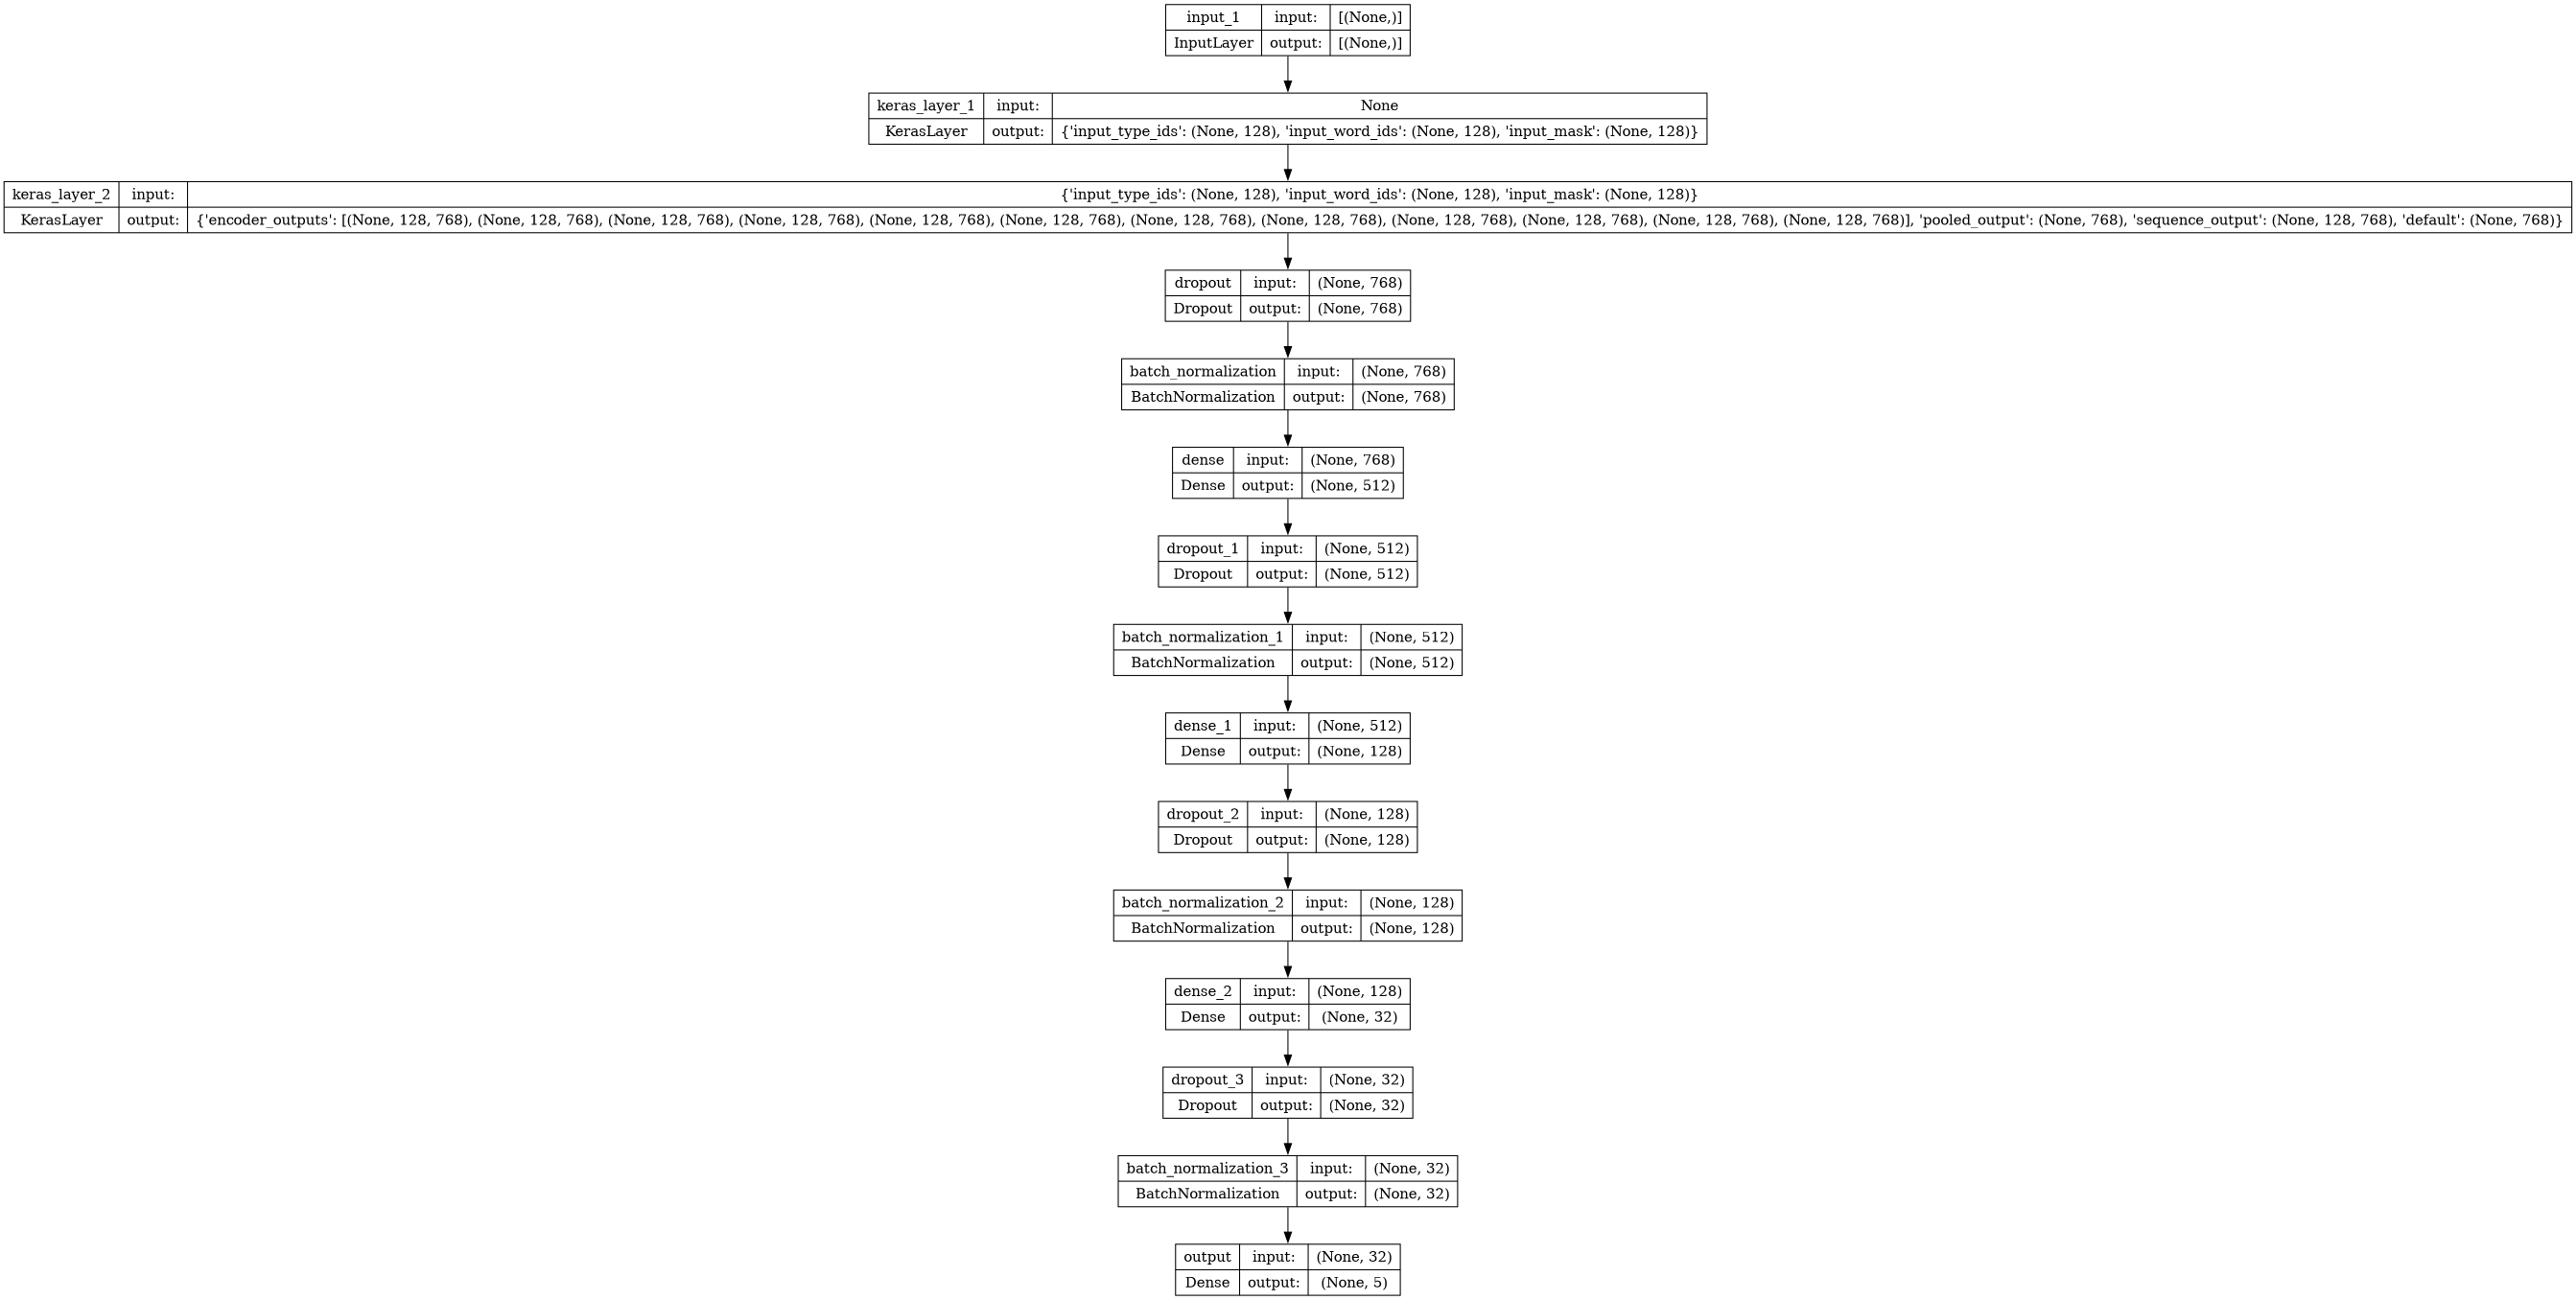

In [32]:

# This will generate a plot of the model architecture and save it as a file
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_architecture.png')


In [33]:
# Training the model
epochs = 10
history = model.fit(X_train, 
                    y_train,  # Training data and labels
                    validation_data=(X_valid, y_valid),  # Validation data and labels
                    epochs=epochs,  # Number of epochs to train the model
                    verbose=1,  # Verbosity level for logging (1 = progress bar)
                    callbacks=callbacks  # Callbacks for monitoring and early stopping
                   )


Epoch 1/10


I0000 00:00:1734541159.989482      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 [==============================] - ETA: 0s - loss: 2.0526 - accuracy: 0.2457
Epoch 1: val_accuracy improved from -inf to 0.41524, saving model to best_model.h5
674/674 [==============================] - 574s 799ms/step - loss: 2.0526 - accuracy: 0.2457 - val_loss: 1.4935 - val_accuracy: 0.4152 - lr: 2.0000e-05
Epoch 2/10
674/674 [==============================] - ETA: 0s - loss: 1.6797 - accuracy: 0.3669
Epoch 2: val_accuracy did not improve from 0.41524
674/674 [==============================] - 533s 792ms/step - loss: 1.6797 - accuracy: 0.3669 - val_loss: 1.7278 - val_accuracy: 0.2890 - lr: 2.0000e-05
Epoch 3/10
674/674 [==============================] - ETA: 0s - loss: 1.5166 - accuracy: 0.4294
Epoch 3: val_accuracy improved from 0.41524 to 0.56474, saving model to best_model.h5
674/674 [==============================] - 535s 794ms/step - loss: 1.5166 - accuracy: 0.4294 - val_loss: 1.2469 - val_accuracy: 0.5647 - lr: 2.0000e-05
Epoch 4/10
674/674 [===========================

In [34]:
def plot_graphs(history, metric):
    # Plot training and validation metrics for the given metric
    plt.plot(history.history[metric], label=metric)  # Plot training metric
    plt.plot(history.history['val_' + metric], label='val_' + metric)  # Plot validation metric
    plt.xlabel("Epochs")  # X-axis label: Epochs
    plt.ylabel(metric)  # Y-axis label: Metric (e.g., accuracy or loss)
    plt.legend()  # Add legend to differentiate training and validation
    plt.show()  # Display the plot

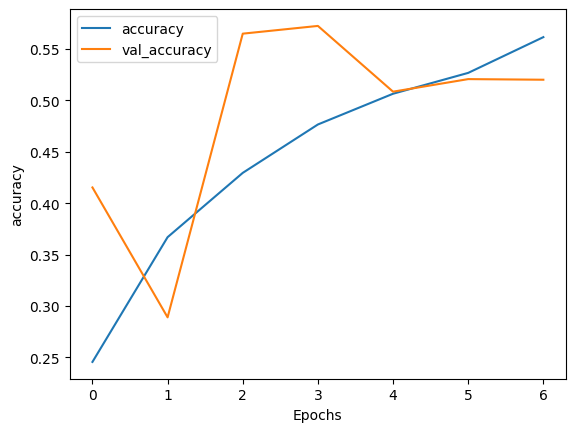

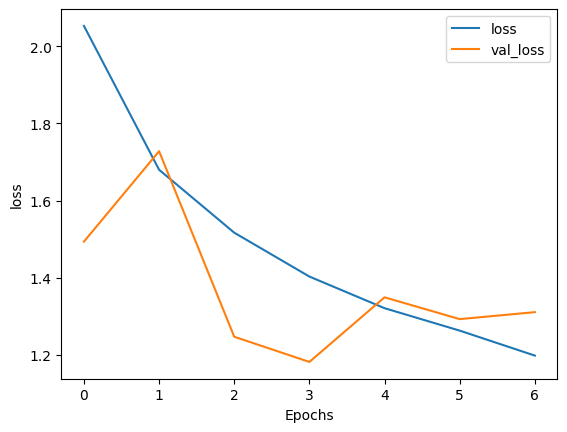

In [35]:
# Plot the accuracy and loss graphs for training and validation
plot_graphs(history, 'accuracy')  # Plot accuracy for both training and validation
plot_graphs(history, 'loss')  # Plot loss for both training and validation

In [36]:
from sklearn.metrics import accuracy_score, log_loss
# Obtain predictions from the BERT model
predictions = model.predict(X_test)

# Convert predictions to class labels (by selecting the class with the highest probability)
predicted_labels = tf.argmax(predictions, axis=1)

# Compute accuracy (percentage of correct predictions)
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", round(accuracy * 100, 4), "%")

# Compute sparse categorical cross-entropy loss
# log_loss expects probabilities as the predictions, so no need to apply argmax
loss = log_loss(y_test, predictions)
print("Sparse Categorical Cross-Entropy Loss:", loss)

438/438 [==============================] - 91s 206ms/step
Accuracy: 56.7076 %
Sparse Categorical Cross-Entropy Loss: 1.1826568035936256


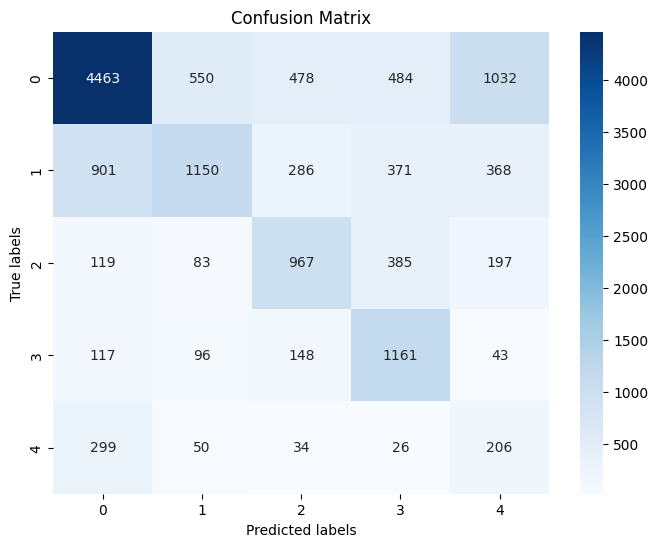

In [37]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(5)], 
            yticklabels=[str(i) for i in range(5)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
import random

# Convert X_test and y_test to lists
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

# Print the lengths of the lists
print(len(X_test_list))  # Length of X_test
print(len(y_test_list))  # Length of y_test


14014
14014


custom_label_mapping = <br>{<br>'open': 0, <br>
                        'not a real question': 1, <br>
                        'off topic': 2, <br>
                        'not constructive': 3, <br>
                        'too localized': 4 <br>
                       }  

In [39]:
# Mapping of label integers to class names
label_to_class_map = {
    0: 'open',
    1: 'not a real question',
    2: 'off topic',
    3: 'not constructive',
    4: 'too localized'
}

#### Check 1

___________________________________________________


TEXT:


Title: 'Website needs force refresh after deploy'  Body: 'After deploying a new version of a website the browser loads everything from its cache from the old webpage until a force refresh is done. Images are old, cookies are old, and some AJAX parts are not working.

How should I proceed to serve the users with the latest version of the page after deploy? 

The webpage is an ASP.Net webpage using IIS7+.'



___________________________________________________


GROUND TRUTH:


open



___________________________________________________



1/1 [==============================] - 1s 778ms/step


PREDICTION:




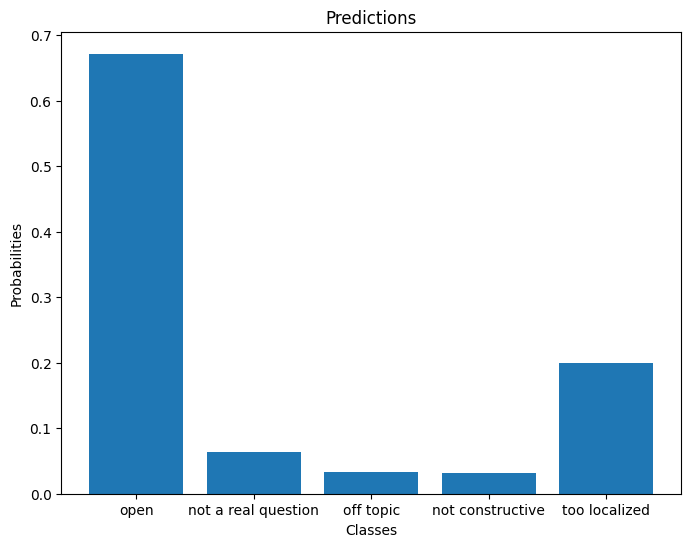




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [40]:
# Generate a random integer between 0 and 14028 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
# Predict the class for the randomly selected text
prediction = model.predict([X_test_list[rand_int]])

print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

# Plot the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()

print("\n\n")
print("___________________________________________________")

# Get the predicted class
predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")

print("\n\n")
# Compare the predicted class with the ground truth
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 2

___________________________________________________


TEXT:


Title: 'Hardware. What is the difference between a port and a bank?'  Body: 'Especially, these days, the distinction between them is very confusing..

For example, NVidia's shared memory is 32-banked, so what they say is in one cycle, 32 data can come out at the same time...
then what is port ? also same issues to cache structure

Could anyone clarify on this ?
Thanks!
'



___________________________________________________


GROUND TRUTH:


off topic



___________________________________________________



1/1 [==============================] - 0s 38ms/step


PREDICTION:




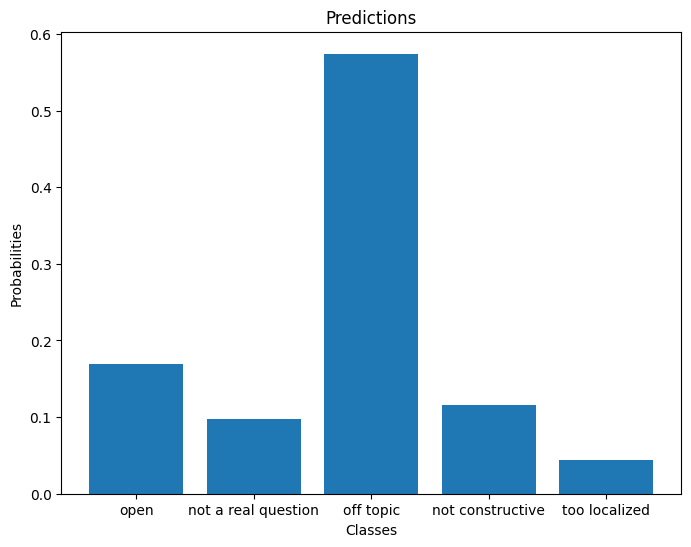




___________________________________________________


PREDICTED CLASS:  off topic



___________________________________________________



CORRECT PREDICTION !!!


In [41]:
# Generate a random integer between 0 and 14028 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
# Predict the class for the randomly selected text
prediction = model.predict([X_test_list[rand_int]])

print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

# Plot the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()

print("\n\n")
print("___________________________________________________")

# Get the predicted class
predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")

print("\n\n")
# Compare the predicted class with the ground truth
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 3

___________________________________________________


TEXT:


Title: 'Why "\n" is true doesn't compare?'  Body: 'Look at the sceene here , please:
http://social.microsoft.com/Forums/getfile/3600/ 
why it's not matching?'



___________________________________________________


GROUND TRUTH:


not a real question



___________________________________________________



1/1 [==============================] - 0s 37ms/step


PREDICTION:




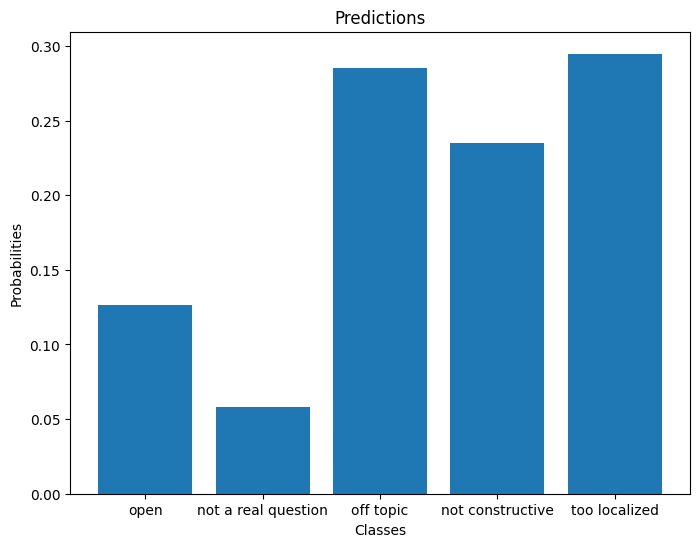




___________________________________________________


PREDICTED CLASS:  too localized



___________________________________________________



WRONG PREDICTION !!!


In [42]:
# Generate a random integer between 0 and 14028 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
# Predict the class for the randomly selected text
prediction = model.predict([X_test_list[rand_int]])

print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

# Plot the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()

print("\n\n")
print("___________________________________________________")

# Get the predicted class
predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")

print("\n\n")
# Compare the predicted class with the ground truth
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 4

___________________________________________________


TEXT:


Title: 'Web Programming with AJAX, Problem with caching (I think)...'  Body: 'Web programmer here - using AJAX (HTML, CSS, JavaScript, AJAX, PHP, MySQL), but for some reason Internet Explorer is acting up (surprise surprise).

AJAX is updating query results on the HTML page, via a PHP script that queries a MySQL Database.

Everything is working fine, except when I use Internet Explorer 8.0 .

There are several php scripts, which allow for the data to be ordered according to certain criteria, and for testing purposes I have attached the mktime field (current time, in the format HH:MM:SS) to the beginning of the results for each query.
When I use IE, these times appear to remain constant, whereas with ALL other browsers these times are correct and display the current time.

I think the issue has something to do with caching or something along those lines anyway.

Any thoughts or suggestions welcome...'



_____________________

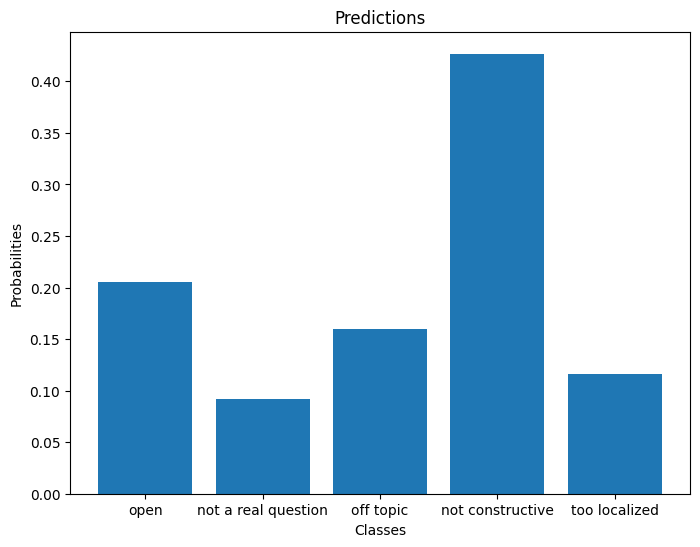




___________________________________________________


PREDICTED CLASS:  not constructive



___________________________________________________



WRONG PREDICTION !!!


In [43]:
# Generate a random integer between 0 and 14028 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
# Predict the class for the randomly selected text
prediction = model.predict([X_test_list[rand_int]])

print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

# Plot the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()

print("\n\n")
print("___________________________________________________")

# Get the predicted class
predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")

print("\n\n")
# Compare the predicted class with the ground truth
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

___________________________________________________


TEXT:


Title: 'ImageMagick requirement for Paperclip plugin'  Body: 'The paperclip plugin says that I need to install ImageMagick in order to use Paperclip. I'm typically really bad at getting things installed and running, so I was wondering if anyone could explain to me the exact specific steps I should take to get it installed and communicating with Paperclip.'



___________________________________________________


GROUND TRUTH:


off topic



___________________________________________________



1/1 [==============================] - 0s 36ms/step


PREDICTION:




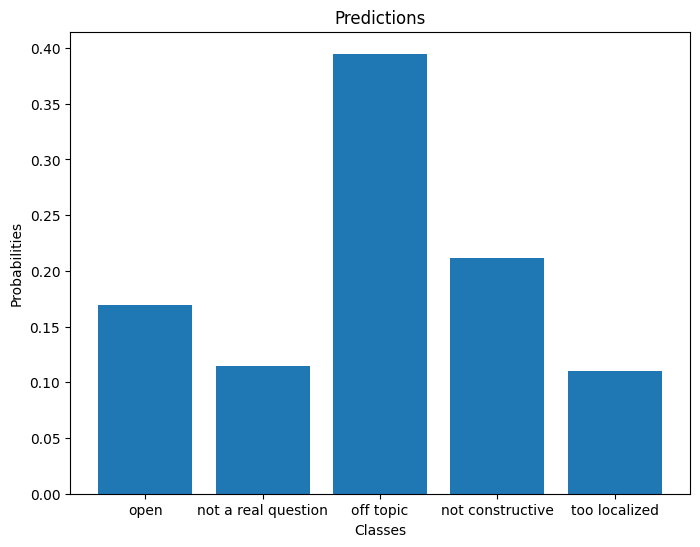




___________________________________________________


PREDICTED CLASS:  off topic



___________________________________________________



CORRECT PREDICTION !!!


In [44]:
# Generate a random integer between 0 and 14028 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
# Predict the class for the randomly selected text
prediction = model.predict([X_test_list[rand_int]])

print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

# Plot the prediction probabilities
plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()

print("\n\n")
print("___________________________________________________")

# Get the predicted class
predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")

print("\n\n")
# Compare the predicted class with the ground truth
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

In [45]:
import pickle

# Assuming `model` is your trained machine learning model
with open('bert_model.pkl', 'wb') as f:
    pickle.dump(model, f)